# Train Model for Distracted Driver Detection

Online Notebook: [Distraction Driver Detection](https://www.kaggle.com/code/andreabernini/distracted-driver)

## Import Libraries

In [1]:
# Install dependencies

# Commented because already present on Kaggle
# ! pip install torch
# ! pip install pytorch-lightning
# ! pip install torchmetrics
# ! pip install timm
# ! pip install albumentations
# ! pip install opencv-python
# ! pip install matplotlib
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install tqdm
# ! pip install plotly

In [2]:
import os
import os.path as osp
from glob import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from enum import Enum

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

import torchmetrics
from torchmetrics.functional import accuracy

/home/ant/miniconda3/envs/multimodal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Static Variables

In [3]:
class StaticDataset(Enum):
    """Class for static training configuration constants"""

    ACTIVITY_MAP = {
        "c0": "Safe driving",
        "c1": "Texting - right",
        "c2": "Talking on the phone - right",
        "c3": "Texting - left",
        "c4": "Talking on the phone - left",
        "c5": "Operating the radio",
        "c6": "Drinking",
        "c7": "Reaching behind",
        "c8": "Hair and makeup",
        "c9": "Talking to passenger",
    }
    DATA_DIR = "src/data/dataset/state-farm-distracted-driver-detection/"
    CSV_FILE_PATH = osp.join(DATA_DIR, "driver_imgs_list.csv")

In [4]:
class StaticLearningParameter(Enum):
    MODEL_NAME_0 = "efficientnet_b0"
    MODEL_NAME_3 = "efficientnet_b3"
    COLOR_MEAN = (0.485, 0.456, 0.406)
    COLOR_STD = (0.229, 0.224, 0.225)
    INPUT_SIZE = 256
    NUM_CLASSES = 10
    BATCH_SIZE = 32
    EPOCHS = 10
    FOLDS = 5
    LR = 1e-3
    GAMMA = 0.98
    DEBUG = True
    TRAIN = False
    SEED = 42
    USE_ALBUMENTATIONS = True

In [5]:
VERBOSE = True  # Set True if you want to see some logs
PLOT = True  # Set True if you want to plot the image

In [6]:
def fix_seed(seed):
    """Fix the seed of the random number generator for reproducibility."""
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

## Dataset Exploration

In [7]:
# Read csv file
print(os.getcwd())
fix_seed(StaticLearningParameter.SEED.value)
df = pd.read_csv("../" + StaticDataset.CSV_FILE_PATH.value)
# Show first 5 lines
df.head(5)

/home/ant/Sapienza/Multimodal_Interaction/multimodal-interaction-project/notebooks


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


### Number of Drivers

In [8]:
# Group by driver
by_drivers = df.groupby("subject")
# list of driver names
unique_drivers = by_drivers.groups.keys()

# Number of drivers in dataset
print("unique drivers: ", len(unique_drivers))
# Average number of images per driver
print("mean of images: ", round(df.groupby("subject").count()["classname"].mean()))

unique drivers:  26
mean of images:  862


In [9]:
# number of training data
train_file_num = len(glob(osp.join(StaticDataset.DATA_DIR.value, "imgs/train/*/*.jpg")))
# number of test data
test_file_num = len(glob(osp.join(StaticDataset.DATA_DIR.value, "imgs/test/*.jpg")))
# number of categories
category_num = len(df["classname"].unique())
print("train_file_num: ", train_file_num)
print("test_file_num: ", test_file_num)
print("category_num: ", category_num)

train_file_num:  0
test_file_num:  0
category_num:  10


### Number of Images per Class

In [10]:
# Number of data per class
px.histogram(
    df, x="classname", color="classname", title="Number of images by categories "
)

### Number of Images per Driver

Number of images per driver sorted by number of images.

In [11]:
drivers_id = pd.DataFrame((df["subject"].value_counts()).reset_index())
drivers_id.columns = ["driver_id", "Counts"]
px.histogram(
    drivers_id,
    x="driver_id",
    y="Counts",
    color="driver_id",
    title="Number of images by subjects ",
)

Number of images per driver sorted by driver id.

In [12]:
# Histogram of number of images per driver
px.histogram(df, x="subject", color="subject", title="Number of images by subjects")

### Image for each Class

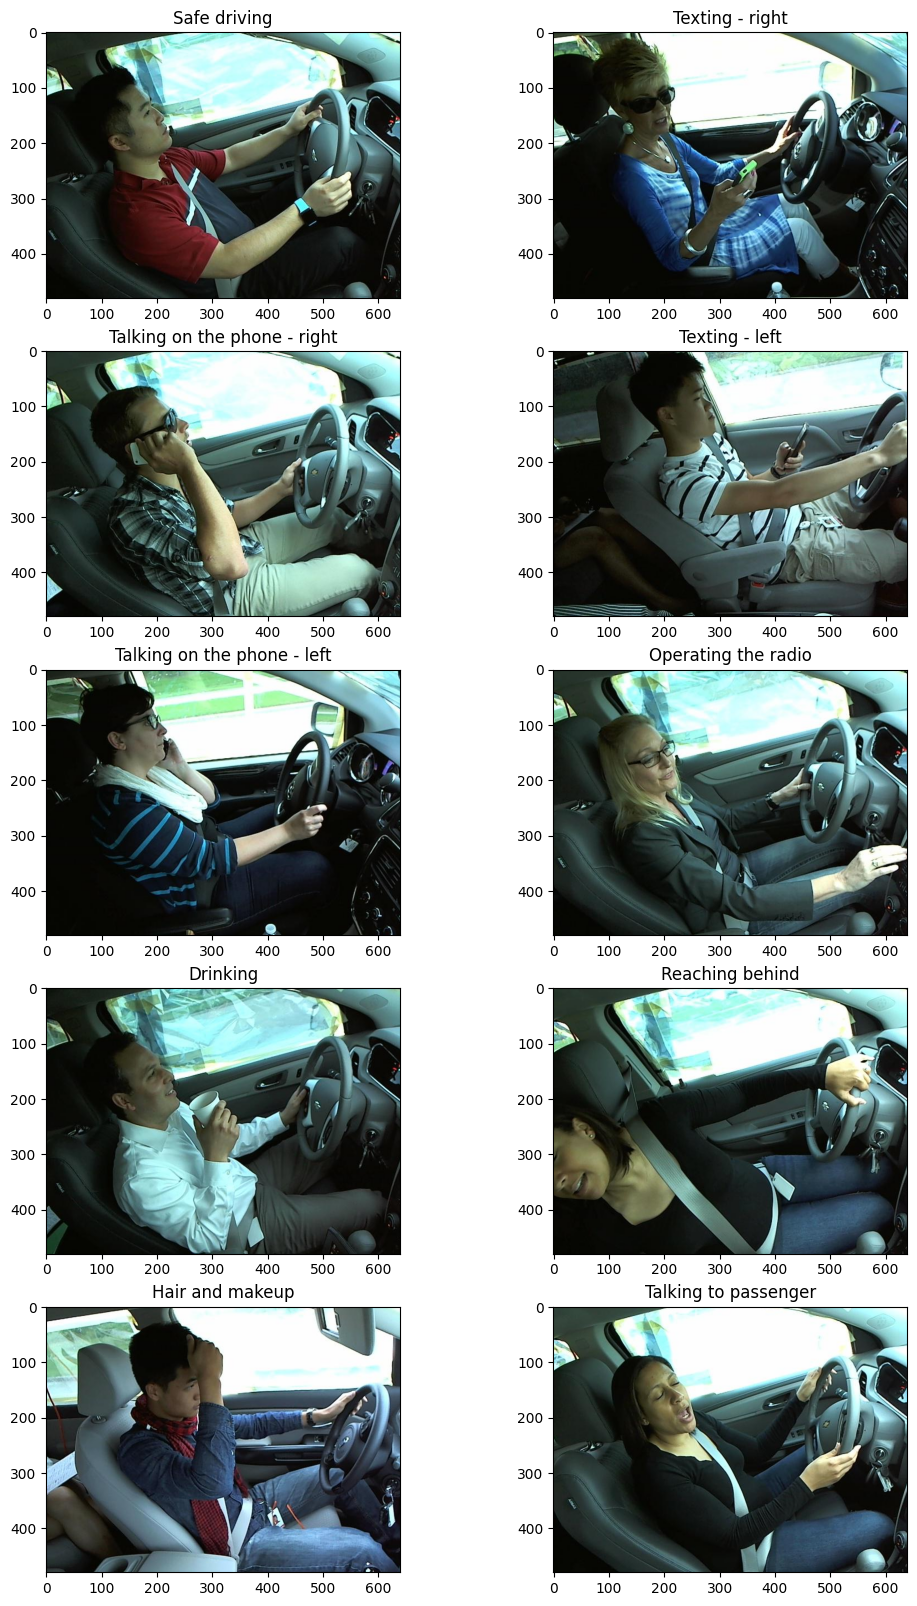

In [13]:
# Draw data for each class
plt.figure(figsize=(12, 20))
for i, (key, value) in enumerate(StaticDataset.ACTIVITY_MAP.value.items()):
    image_dir = osp.join(
        "../" + StaticDataset.DATA_DIR.value, "imgs/train", key, "*.jpg"
    )
    image_path = glob(image_dir)[0]
    image = cv2.imread(image_path)[:, :, (2, 1, 0)]
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
    plt.title(value)

## Preprocessing

In [14]:
# Add file path column
df["file_path"] = df.apply(
    lambda x: osp.join(
        "../" + StaticDataset.DATA_DIR.value, "imgs/train", x.classname, x.img
    ),
    axis=1,
)

# Add Column by Converting Correct Answer Labels to Numbers
df["class_num"] = df["classname"].map(lambda x: int(x[1]))
df.head(5)

,subject,classname,img,file_path,class_num
0,p002,c0,img_44733.jpg,../src/data/dataset/state-farm-distracted-driv...,0
1,p002,c0,img_72999.jpg,../src/data/dataset/state-farm-distracted-driv...,0
2,p002,c0,img_25094.jpg,../src/data/dataset/state-farm-distracted-driv...,0
3,p002,c0,img_69092.jpg,../src/data/dataset/state-farm-distracted-driv...,0
4,p002,c0,img_92629.jpg,../src/data/dataset/state-farm-distracted-driv...,0


## Dataset

### Custom Dataset

In [15]:
class Dataset(data.Dataset):
    """
    Attributes
    ----------
    df : DataFrame
        class_num, dataframe with column file_path
    phase : 'train' or 'val'
        Set learning or training.
    transform : object
        an instance of the preprocessing class
    """

    def __init__(self, df, phase, transform):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):
        """returns the number of images"""
        return len(self.df)

    def __getitem__(self, index):
        """Get Tensor format data of preprocessed image"""
        image = self.pull_item(index)
        return image, self.df.iloc[index]["class_num"]

    def pull_item(self, index):
        """Get Tensor format data of image"""
        # 1. Image loading
        image_path = self.df.iloc[index]["file_path"]
        image = cv2.imread(image_path)[:, :, (2, 1, 0)]
        # 2. Perform pretreatment
        return self.transform(self.phase, image)

### Data Transformations

In [16]:
class DataTransform:
    """
    Image and annotation preprocessing classes.
    It behaves differently during training and during validation.
    Set the image size to input_size x input_size.
    Data augmentation during training.


    Attributes
    ----------
    input_size : int
        The size of the resized image.
    color_mean : (R, G, B)
        Average value for each color channel.
    color_std : (R, G, B)
        Standard deviation for each color channel.
    """

    def __init__(
        self,
        input_size,
        color_mean,
        color_std,
        use_albumentations=StaticLearningParameter.USE_ALBUMENTATIONS.value,
    ):
        if use_albumentations:
            # Albumentations Transformations
            self.data_transform = {
                # Implement only train
                "train": A.Compose(
                    [
                        A.HorizontalFlip(p=0.5),
                        A.Rotate(-10, 10),
                        A.Resize(input_size, input_size),  # resize(input_size)
                        # Standardization of color information
                        A.Normalize(color_mean, color_std),
                        ToTensorV2(),
                    ]
                ),
                "val": A.Compose(
                    [
                        A.Resize(input_size, input_size),  # resize(input_size)
                        # Standardization of color information
                        A.Normalize(color_mean, color_std),
                        ToTensorV2(),
                    ]
                ),
            }
        else:
            # PyTorch Transformations
            self.data_transform = {
                # Implement only train
                "train": transforms.Compose(
                    [
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation((-10, 10)),
                        transforms.Resize(input_size),  # resize(input_size)
                        transforms.Normalize(color_mean, color_std),
                        transforms.ToTensor(),
                    ]
                ),
                "val": transforms.Compose(
                    [
                        transforms.Resize(input_size),  # resize(input_size)
                        transforms.Normalize(color_mean, color_std),
                        transforms.ToTensor(),
                    ]
                ),
            }

    def __call__(self, phase, image):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            Specifies the preprocessing mode.
        """
        transformed = self.data_transform[phase](image=image)
        return transformed["image"]

### Split Dataset

In [17]:
def create_dataset(
    df,
    seed=StaticLearningParameter.SEED.value,
    input_size=StaticLearningParameter.INPUT_SIZE.value,
    color_mean=StaticLearningParameter.COLOR_MEAN.value,
    color_std=StaticLearningParameter.COLOR_STD.value,
):
    """Create dataset for training and validation.

    Args:
        seed (int, optional): Random seed.
            Defaults to StaticTrain.SEED.value.
        input_size (int, optional): Input size.
            Defaults to StaticDataTransform.INPUT_SIZE.value.
        color_mean (tuple, optional): Color mean.
            Defaults to StaticDataTransform.COLOR_MEAN.value.
        color_std (tuple, optional): Color standard deviation.
            Defaults to StaticDataTransform.COLOR_STD.value.

    Returns:
        train_dataset, val_dataset: Dataset for training and validation.
    """
    # data division
    df_train, df_val = train_test_split(df, stratify=df["subject"], random_state=seed)
    if VERBOSE:
        print("train num:", len(df_train))
        print("val num:", len(df_val))

    # dataset creation
    train_dataset = Dataset(
        df_train,
        phase="train",
        transform=DataTransform(
            input_size=input_size, color_mean=color_mean, color_std=color_std
        ),
    )

    val_dataset = Dataset(
        df_val,
        phase="val",
        transform=DataTransform(
            input_size=input_size, color_mean=color_mean, color_std=color_std
        ),
    )

    if VERBOSE:
        print("train dataset size:", len(train_dataset))
        print("val dataset size:", len(val_dataset))

    if PLOT:
        # Data retrieval example
        image, label = train_dataset[0]
        plt.imshow(image.permute(1, 2, 0))
        plt.title(label)
        plt.show()

    return train_dataset, val_dataset

### Create Data Loaders

In [18]:
def create_datamodule(
    train_dataset, val_dataset, batch_size=StaticLearningParameter.BATCH_SIZE.value
):
    """
    Create dataloader for training and validation.

    Args:
        train_dataset: Dataset for training.
        val_dataset: Dataset for validation.
        batch_size (int, optional): Batch size.
            Defaults to StaticDataLoader.BATCH_SIZE.value.

    Returns:
        datamodule: Dataloader for training and validation.
    """
    datamodule = pl.LightningDataModule.from_datasets(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size if torch.cuda.is_available() else 4,
        num_workers=int(os.cpu_count()),
    )

    if VERBOSE:
        print("data module created")

    return datamodule

## Model

In [19]:
class LitEfficientNet(LightningModule):
    """LightningModule for EfficientNet."""

    def __init__(
        self,
        model,
        lr=StaticLearningParameter.LR.value,
        gamma=StaticLearningParameter.GAMMA.value,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.num_classes = len(StaticDataset.ACTIVITY_MAP.value.items())

    def forward(self, x):
        """Forward propagation."""
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        """
        Training step.

        Args:
            batch: batch data
            batch_idx: batch index
        """
        inputs, labels = batch
        logits = self(inputs)
        loss = F.nll_loss(logits, labels)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        """
        Evaluation step.

        Args:
            batch: batch data
            stage: stage name
        """
        inputs, labels = batch
        logits = self(inputs)
        loss = F.nll_loss(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, labels)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        """
        Validation step.

        Args:
            batch: batch data
            batch_idx: batch index
        """
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        """
        Test step.

        Args:
            batch: batch data
            batch_idx: batch index
        """
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        """Configure optimizers."""

        """
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            # weight_decay=5e-4,
        )
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.gamma)

        # criterion = nn.CrossEntropyLoss()  # loss function

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Train

In [20]:
def train(datamodule, class_names=StaticDataset.ACTIVITY_MAP.value.items()):
    """Train the model with Pytorch Lightning.

    Args:
        datamodule: Dataloader for training and validation.
        class_names (list, optional): List of class names.

    """
    # Create model
    # NOTE: MODEL_NAME_0 = "efficientnet_b0"
    # NOTE: MODEL_NAME_3 = "efficientnet_b3" this is used in the reference code
    efficient_model = timm.create_model(
        StaticLearningParameter.MODEL_NAME_0.value,
        pretrained=True,
        num_classes=len(class_names),
    )

    model = LitEfficientNet(efficient_model, lr=StaticLearningParameter.LR.value)

    trainer = Trainer(
        max_epochs=StaticLearningParameter.EPOCHS.value,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices="auto",
        logger=CSVLogger(save_dir="logs/"),
        callbacks=[
            LearningRateMonitor(logging_interval="step"),
            TQDMProgressBar(refresh_rate=10),
        ],
    )
    trainer.fit(model, datamodule=datamodule)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train num: 16818
val num: 5606
train dataset size: 16818
val dataset size: 5606


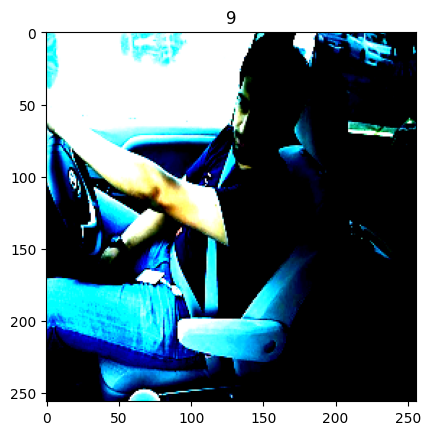

data module created
torch.Size([3, 256, 256])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 4.0 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.081    Total estimated model params size (MB)


Epoch 3:  32%|███▏      | 170/526 [00:46<01:38,  3.63it/s, v_num=3, val_loss=0.0859, val_acc=0.989]

/home/ant/miniconda3/envs/multimodal/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [21]:
### Operation check ###
train_dataset, val_dataset = create_dataset(df)

### Create DataLoader ###
datamodule = create_datamodule(train_dataset, val_dataset)

if VERBOSE:
    image = datamodule.train_dataloader().dataset[0]
    print(image[0].shape)

### Train the model ###
train(datamodule)